In [1]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
%matplotlib notebook
import random

In [2]:
# Read in Data
TicketData = pd.read_csv('Data/MasterTicketData.csv')

In [3]:
# Initial Data frame characteristics
num_events = TicketData['event_id'].count()
num_events_w_face_values = TicketData[TicketData['face_value'].str.contains('\$')]['event_id'].count()

print("Total number of events: %s" % num_events)
print("Total number of events with face values: %s \n" % num_events_w_face_values)
print("City counts: \n")
print TicketData['city'].value_counts()

Total number of events: 3126
Total number of events with face values: 1436 

City counts: 

New York         383
Nashville        323
Los Angeles      293
Chicago          235
Portland         207
Philadelphia     196
San Francisco    195
Boston           195
Dallas           194
Atlanta          182
Seattle          156
Denver           153
Houston          135
Austin           130
Miami             55
Miami Beach       48
Oakland           43
Miami Gardens      3
Name: city, dtype: int64


## Initial Data Filtering and Processing

In [4]:
# Get rid of rows where face value is non-numeric
TicketData = TicketData[TicketData['face_value'].str.contains('\$')]

# Remove dollar sign from the face_value field (so that we can compare it to other price fields)
TicketData['face_value'] = TicketData['face_value'].map(lambda x: x.lstrip('$'))

# Convert face_value column to numeric type
TicketData['face_value'] = pd.to_numeric(TicketData['face_value'], errors='ignore')

# Calculate delta between min stubhub price and face value
TicketData['FV_delta'] = TicketData['min_price'] - TicketData['face_value']

# Calculate delta between max stubhub price and face value
TicketData['maxPrice_FV_delta'] = TicketData['max_price'] - TicketData['face_value']

# Convert FV_delta to log form
TicketData['FV_delta_log'] = np.log(TicketData['FV_delta'])

# Get rid of event_id #9478397 which is an outlier (stubhub ticket price is $711,671)
TicketData = TicketData[TicketData['event_id'] != 9478397]

# Display result.
TicketData[['date', 'artist', 'venue', 'city', 'min_price', 'max_price', 'face_value', 
            'FV_delta', 'FV_delta_log', 'maxPrice_FV_delta']].head()

,date,artist,venue,city,min_price,max_price,face_value,FV_delta,FV_delta_log,maxPrice_FV_delta
0,2016-08-07T20:00:00-0400,Janet Jackson,Philips Arena,Atlanta,49.70,2222.22,45.00,4.70,1.547563,2177.22
3,2016-06-09T19:30:00-0400,Selena Gomez,Philips Arena,Atlanta,85.04,1500.00,35.00,50.04,3.912823,1465.00
4,2016-04-23T20:00:00-0400,Ciara,Center Stage Theatre,Atlanta,55.99,119.00,29.00,26.99,3.295466,90.00
7,2016-03-17T20:00:00-0400,Joan Baez,Symphony Hall Atlanta,Atlanta,35.92,392.00,29.50,6.42,1.859418,362.50
8,2016-06-29T19:00:00-0400,Demi Lovato and Nick Jonas,Philips Arena,Atlanta,46.86,1749.00,29.95,16.91,2.827905,1719.05


In [5]:
# New Dataframe characteristics
num_events = TicketData['event_id'].count()

print("Total number of events: %s \n" % num_events)

print("Max FV_delta: %s" %TicketData['FV_delta'].max())
print("Max maxPrice_FV_delta: %s" % TicketData['maxPrice_FV_delta'].max())

Total number of events: 1435 

Max FV_delta: 503.0
Max maxPrice_FV_delta: 99954.0


<IPython.core.display.Javascript object>


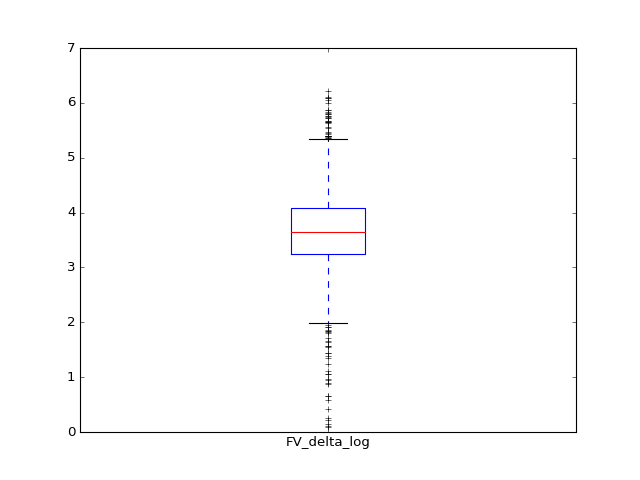

In [6]:
TicketData['FV_delta_log'].plot.box()

## Get rid of outliers

In [7]:
def RemoveOutliersFromDataFrame(df, column_name):
    q1 = df[column_name].quantile(0.25)
    q3 = df[column_name].quantile(0.75)
    IQR = q3 - q1
    df.drop(df[df[column_name] > q3+1.5*IQR].index, inplace = True)
    df.drop(df[df[column_name] < q1-1.5*IQR].index, inplace = True)
    return df

<IPython.core.display.Javascript object>


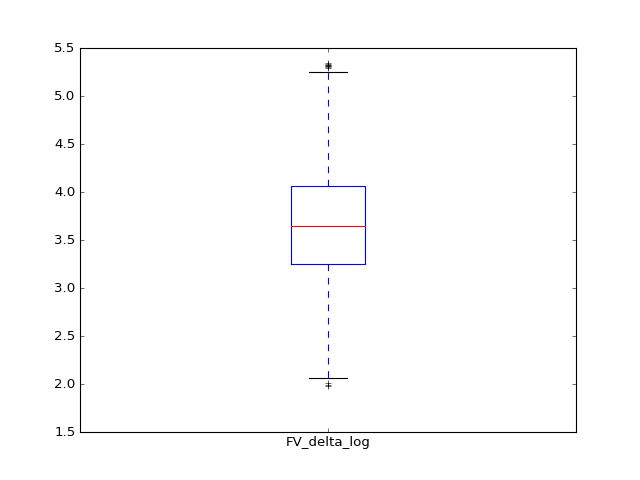

In [8]:
# Remove outliers from data
TicketData = RemoveOutliersFromDataFrame(TicketData, 'FV_delta_log')

# Drop negative values 
# Not sure if we want to do this - might be OK to have negative values. I.e., concert demand was not high
# TicketData.drop(TicketData[TicketData['FV_delta'] < 0].index, inplace=True)
TicketData['FV_delta_log'].plot.box()

In [9]:
print TicketData.count()
TicketData.head()

event_id             1363
date                 1363
artist               1363
venue                1363
min_price            1363
max_price            1363
total_postings       1363
total_tickets        1363
city                 1363
state                1363
ticket_vendor        1363
face_value           1363
sold_out             1363
sk_artist_id         1363
days_to_show         1363
num_blogs            1363
num_news             1363
num_reviews          1363
discovery            1363
familiarity          1363
hotttnesss           1363
num_years_active     1305
FV_delta             1363
maxPrice_FV_delta    1363
FV_delta_log         1328
dtype: int64


,event_id,date,artist,venue,min_price,max_price,total_postings,total_tickets,city,state,...,num_blogs,num_news,num_reviews,discovery,familiarity,hotttnesss,num_years_active,FV_delta,maxPrice_FV_delta,FV_delta_log
3,9408915,2016-06-09T19:30:00-0400,Selena Gomez,Philips Arena,85.04,1500,106,359,Atlanta,GA,...,9475,2202,7,0.4399476127099588,0.770825,0.862321,8,50.04,1465.00,3.912823
4,9411812,2016-04-23T20:00:00-0400,Ciara,Center Stage Theatre,55.99,119,14,89,Atlanta,GA,...,8129,962,52,0.39156665147655895,0.749624,0.729409,14,26.99,90.00,3.295466
8,9425600,2016-06-29T19:00:00-0400,Demi Lovato and Nick Jonas,Philips Arena,46.86,1749,182,780,Atlanta,GA,...,6062,1776,13,0.42707395045850144,0.769929,0.835224,14,16.91,1719.05,2.827905
10,9428103,2016-04-08T20:30:00-0400,They Might Be Giants,Variety Playhouse,60.32,1112,13,73,Atlanta,GA,...,2083,231,167,0.3685639791426707,0.70152,0.619015,34,35.32,1087.00,3.564449
11,9432150,2016-05-04T19:00:00-0400,Prong,Masquerade Atlanta,48.37,70,4,18,Atlanta,GA,...,1110,289,14,0.40972813200151115,0.61652,0.589147,30,32.37,54.00,3.477232


## Get rid of non-numeric values

In [10]:
# Get rid of rows where Echonest did not return any data
TicketData = TicketData[TicketData['num_news'] != 'error_5']
# Get rid of rows where num_years_active has a null value
TicketData = TicketData[TicketData['num_years_active'].isnull() == False]
# Get rid of rows where FV_delta_log is null (meaning FV_delta was negative)
TicketData = TicketData[TicketData['FV_delta_log'].isnull() == False]
print TicketData.count()

event_id             1260
date                 1260
artist               1260
venue                1260
min_price            1260
max_price            1260
total_postings       1260
total_tickets        1260
city                 1260
state                1260
ticket_vendor        1260
face_value           1260
sold_out             1260
sk_artist_id         1260
days_to_show         1260
num_blogs            1260
num_news             1260
num_reviews          1260
discovery            1260
familiarity          1260
hotttnesss           1260
num_years_active     1260
FV_delta             1260
maxPrice_FV_delta    1260
FV_delta_log         1260
dtype: int64


In [11]:
# Uncomment this in order to save processed dataframe as CSV
TicketData.to_csv(path_or_buf="Data/ProcessedTicketData.csv", index=False)